Joints 2d:  torch.Size([1, 1, 22, 2])
camera_T :  torch.Size([3, 3, 120])
camera_R :  torch.Size([3, 6, 120])
camera_center :  torch.Size([3, 2])
focal_length :  torch.Size([3, 1])
Joints 3d:  torch.Size([3, 120, 22, 3])
tensor([[[-2.4757],
         [-2.3714],
         [-2.4426],
         [-2.5765],
         [-1.9976],
         [-2.1903],
         [-2.6872],
         [-1.6454],
         [-1.8269],
         [-2.7414],
         [-1.5469],
         [-1.8858],
         [-2.9583],
         [-2.8155],
         [-2.9014],
         [-2.9973],
         [-2.7991],
         [-3.0023],
         [-2.7338],
         [-2.9216],
         [-2.8354],
         [-2.8851]],

        [[ 1.9662],
         [ 1.9881],
         [ 1.9725],
         [ 1.9726],
         [ 2.0639],
         [ 2.2169],
         [ 1.9689],
         [ 2.1488],
         [ 2.3629],
         [ 1.9820],
         [ 2.2096],
         [ 2.3999],
         [ 2.0339],
         [ 2.0519],
         [ 1.9675],
         [ 2.0426],
         [ 2.1294

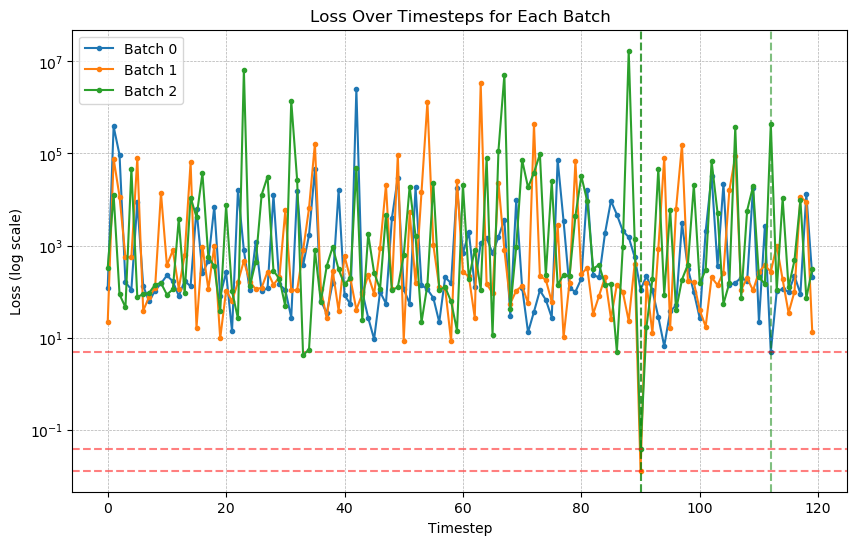

Minimum loss timestep:  90
Minimum loss value:  0.0371478796005249


In [ ]:
import numpy as np
import torch as th
import sys
sys.path.append('/home/mint/Dev/HumanMotion/Diffusion-Noise-Optimization/')
from sample.reprojection_condition import reprojection_loss

# 2D joints
target_joints_2d = np.array([[305.5, 278.5], [329.0, 278.0], [282.0, 279.0], [308.25, 213.5], [370.0, 364.0], [245.0, 366.0], [309.34999999999997, 187.5], [410.0, 448.0], [209.0, 451.0], [309.90000000000003, 174.5], [417.0, 481.0], [199.0, 484.0], [311.0, 148.5], [329.95000000000005, 161.75], [290.95000000000005, 161.25], [311.0, 118.5], [350.0, 149.0], [272.0, 148.0], [406.0, 136.0], [211.0, 130.0], [431.0, 84.0], [195.0, 77.0]])
# Normalized to 0-1
h, w, _ = (574, 575, 3)
target_joints_2d[..., 0] = target_joints_2d[..., 0] / h
target_joints_2d[..., 1] = target_joints_2d[..., 1] / w
target_joints_2d = target_joints_2d[None, None, :, :]
target_joints_2d = th.tensor(target_joints_2d, dtype=th.float32)
print("Joints 2d: ", target_joints_2d.shape)

dat = '/home/mint/Dev/HumanMotion/Diffusion-Noise-Optimization/save/mdm_avg_dno/samples_000500000_avg_seed20_a_person_is_standing_stilll/pose_editing_reprojection_dno/results.npy'
# dat = '/home/mint/Dev/HumanMotion/Diffusion-Noise-Optimization/save/mdm_avg_dno/samples_000500000_avg_seed20_a_person_is_standing/pose_editing_reprojection_dno/results.npy'
# dat = '/home/mint/Dev/HumanMotion/Diffusion-Noise-Optimization/save/mdm_avg_dno/samples_000500000_avg_seed20_a_standing_still_person/pose_editing_reprojection_dno/results.npy'
dat = np.load(dat, allow_pickle=True).item()
cam_dat = th.load('/home/mint/Dev/HumanMotion/Diffusion-Noise-Optimization/save/mdm_avg_dno/samples_000500000_avg_seed20_a_person_is_standing_stilll/pose_editing_reprojection_dno/cam_dict.pt')
# cam_dat = th.load('/home/mint/Dev/HumanMotion/Diffusion-Noise-Optimization/save/mdm_avg_dno/samples_000500000_avg_seed20_a_person_is_standing/pose_editing_reprojection_dno/cam_dict.pt')
# cam_dat = th.load('/home/mint/Dev/HumanMotion/Diffusion-Noise-Optimization/save/mdm_avg_dno/samples_000500000_avg_seed20_a_standing_still_person/pose_editing_reprojection_dno/cam_dict.pt')

joints_3d = dat['motion']   # B x 22 x 3 x T
cam_dict = cam_dat
for k, v in cam_dict.items():
    print(k, ": ", v.shape)
joints_3d = th.tensor(joints_3d, dtype=th.float32)[1:, ...]
joints_3d = joints_3d.permute(0, 3, 1, 2)
print("Joints 3d: ", joints_3d.shape)
loss, joints_3d_projection = reprojection_loss(joints_3d, target_joints_2d, cam_dict)
print(joints_3d_projection[0][90])
print(joints_3d_projection[1][90])
print(joints_3d_projection[2][90])
print("Loss: ", loss.shape)

loss = loss.detach().cpu().numpy()
loss = loss.sum(axis=(2, 3))
import matplotlib.pyplot as plt
batch_size = loss.shape[0]
# Iterate over each batch
plt.figure(figsize=(10, 6))
for i in range(batch_size):
    min_loss_timestep = np.argmin(loss[i, :])
    min_loss_value = loss[i, min_loss_timestep]

    plt.plot(loss[i, :], label=f"Batch {i}", marker="o", markersize=3, linestyle="-")
    plt.axhline(y=min_loss_value, color="r", linestyle="--", alpha=0.5)  # Highlight min loss
    plt.axvline(x=min_loss_timestep, color="g", linestyle="--", alpha=0.5)  # Highlight min timestep

# Apply log scale
plt.yscale("log")

# Labels and title
plt.xlabel("Timestep")
plt.ylabel("Loss (log scale)")
plt.title("Loss Over Timesteps for Each Batch")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show plot
plt.show()


# Plot joints 2d on the minimum loss timestep
min_loss_timestep = min_loss_timestep.item()
print("Minimum loss timestep: ", min_loss_timestep)
min_loss_value = min_loss_value.item()
print("Minimum loss value: ", min_loss_value)
joints_3d_projection = joints_3d_projection.detach().cpu().numpy()
# joints_3d_projection = joints_3d_projection[:, min_loss_timestep, ...]

import plotly.graph_objects as go
fig = go.Figure()
for i in range(batch_size):
    fig.add_trace(go.Scatter(x=target_joints_2d[0, 0, :, 0], y=1-target_joints_2d[0, 0, :, 1], mode='markers', name='Target 2D Joints'))
    fig.add_trace(go.Scatter(x=joints_3d_projection[i, min_loss_timestep, :, 0], y=1-joints_3d_projection[i, min_loss_timestep, :, 1], mode='markers', name='Projected 3D Joints'))
    fig.update_layout(title_text="2D Joints and Projected 3D Joints on Minimum Loss Timestep")
    # Make it's square grid and equal aspect ratio with 0-1 range
    fig.update_xaxes(range=[0, 1])
    fig.update_yaxes(range=[0, 1])
    fig.update_xaxes(scaleanchor="y", scaleratio=1)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_layout(width=800, height=800)
fig.show()